<h2>Lion mail drive link to the model: <a href="https://drive.google.com/drive/folders/13LU6Z5qObxH6pxdUo9N531-eqFGlvAIV?usp=sharing">https://drive.google.com/drive/folders/13LU6Z5qObxH6pxdUo9N531-eqFGlvAIV?usp=sharing</a></h2>

## Load Data

In [25]:
#Generate dataset
import os
import pandas as pd
import numpy as np
from PIL import Image


#Load Training images and labels
train_directory = "./data/kaggle_train_128/train_128" #TODO: Enter path for train128 folder (hint: use os.getcwd())
image_list=[]
label_list=[]
for sub_dir in os.listdir(train_directory):
    print("Reading folder {}".format(sub_dir))
    sub_dir_name=os.path.join(train_directory,sub_dir)
    for file in os.listdir(sub_dir_name):
        filename = os.fsdecode(file)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_list.append(np.array(Image.open(os.path.join(sub_dir_name,file))))
            label_list.append(int(sub_dir))
X_train=np.array(image_list)
y_train=np.array(label_list)

#Load Test images
test_directory = "./data/kaggle_test_128/test_128"#TODO: Enter path for test128 folder (hint: use os.getcwd())
test_image_list=[]
test_df = pd.DataFrame([], columns=['Id', 'X'])
print("Reading Test Images")
for file in os.listdir(test_directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"):
        test_df = test_df.append({
            'Id': filename,
            'X': np.array(Image.open(os.path.join(test_directory,file)))
        }, ignore_index=True)
        
test_df['s'] = [int(x.split('.')[0]) for x in test_df['Id']]
test_df = test_df.sort_values(by=['s'])
test_df = test_df.drop(columns=['s'])
X_test = np.stack(test_df['X'])


print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)

Reading folder 0
Reading folder 1
Reading folder 2
Reading folder 3
Reading folder 4
Reading Test Images
Training data shape:  (15000, 128, 128, 3)
Training labels shape:  (15000,)
Test data shape:  (3500, 128, 128, 3)


# Incremental steps are used to train the model.

## Step 1: transfer learning with ResNet50V2 and fine tuning with data augmentation

## Step 2: transfer learning with DenseNet121 and fine tuning with data augmentation

## Step 3: Concactenate both models and do a final transfer learning


<h5>Lion mail drive link to the model: <a href="https://drive.google.com/drive/folders/13LU6Z5qObxH6pxdUo9N531-eqFGlvAIV?usp=sharing">https://drive.google.com/drive/folders/13LU6Z5qObxH6pxdUo9N531-eqFGlvAIV?usp=sharing</a></h5>

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#from tensorflow import ConfigProto
#from tensorflow import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\nguye\anaconda3\envs\envTF24\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [27]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [28]:
# YOUR CODE HERE
# suffle data
shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
y_train = y_train[shuffler]

y=tf.keras.utils.to_categorical(y_train)
# validation data and training data
Xval=X_train[0:2000]
yval=y[0:2000]
Xtrain=X_train[2000:]
ytrain=y[2000:]


In [5]:
#for future data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
bs=64
epc=13#not used


# Step 1a:
transfer learning with ResNet50V2 using only the original training data (with 13% of the data for validation)

In [15]:
#model  ResNet50 pretrained
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#base_model = InceptionV3(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')


from tensorflow.keras.applications.resnet_v2 import ResNet50V2
base_model = ResNet50V2( include_top=False, weights="imagenet")
preprocess_input =tf.keras.applications.resnet_v2.preprocess_input #to ensure proper input format into resnet50V2

for layer in base_model.layers: #Freeze resnet50v2 layers for Transfer learning 
    layer.trainable = False

In [6]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.keras import regularizers
#input
inputs = tf.keras.Input(shape=(128, 128, 3))
# Preprocess for ResNet50v2layer 
x = preprocess_input(inputs)
# ResNet50v2layer 
x = base_model(x, training=False)
x=GlobalAveragePooling2D()(x)


# we add dense layers so that the model can learn more complex functions and classify for better results.
# Regularization to avoid overfitting
x=Dense(2048,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4))(x) 
x=Dropout(0.2)(x)
x=Dense(2048,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4))(x)
x=Dropout(0.2)(x)
x=Dense(512,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4))(x)
x=Dense(256,activation='relu')(x)
preds=Dense(5,activation='softmax')(x)


model=Model(inputs=inputs,outputs=preds)

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [44]:
history=model.fit(x=Xtrain, y=ytrain,
                   batch_size = bs,
                   epochs = 6,
                   validation_data=(Xval, yval),shuffle=True)


Epoch 1/6
204/204 [==============================] - 25s 111ms/step - loss: 3.5372 - acc: 0.4813 - val_loss: 3.1002 - val_acc: 0.6270
Epoch 2/6
204/204 [==============================] - 15s 72ms/step - loss: 2.9895 - acc: 0.6542 - val_loss: 2.8519 - val_acc: 0.6725
Epoch 3/6
204/204 [==============================] - 15s 72ms/step - loss: 2.7486 - acc: 0.7246 - val_loss: 2.7742 - val_acc: 0.6900
Epoch 4/6
204/204 [==============================] - 15s 73ms/step - loss: 2.5843 - acc: 0.7615 - val_loss: 2.7069 - val_acc: 0.6895
Epoch 5/6
204/204 [==============================] - 15s 73ms/step - loss: 2.4128 - acc: 0.8150 - val_loss: 2.6972 - val_acc: 0.6930
Epoch 6/6
204/204 [==============================] - 15s 73ms/step - loss: 2.2597 - acc: 0.8605 - val_loss: 2.6312 - val_acc: 0.7250


In [45]:
#Save step 1 for potential reuse
model.save("model1")

INFO:tensorflow:Assets written to: model1\assets


# Step 1b

More transfer learning using conservative data augmentation on the same data



In [46]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        vertical_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)
        #brightness_range=(0.3, 1.4),
        #preprocessing_function=add_noise)

train_generator = train_datagen.flow(Xtrain, ytrain, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

In [47]:
#step2 
# start from where we ended in step 1 (same weights)
model2 = tf.keras.models.load_model("model1")
history=model2.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = 6,
                   validation_data=(Xval, yval),shuffle=True)
model2.save("model2") #Save step 2 for potential reuse

Epoch 1/6
203/203 [==============================] - 51s 234ms/step - loss: 2.6573 - acc: 0.6589 - val_loss: 2.1799 - val_acc: 0.8515
Epoch 2/6
203/203 [==============================] - 42s 206ms/step - loss: 2.0680 - acc: 0.8525 - val_loss: 1.8727 - val_acc: 0.9060
Epoch 3/6
203/203 [==============================] - 41s 203ms/step - loss: 1.8384 - acc: 0.8919 - val_loss: 1.6484 - val_acc: 0.9290
Epoch 4/6
203/203 [==============================] - 41s 204ms/step - loss: 1.6520 - acc: 0.9122 - val_loss: 1.7058 - val_acc: 0.8705
Epoch 5/6
203/203 [==============================] - 41s 204ms/step - loss: 1.4945 - acc: 0.9222 - val_loss: 1.3952 - val_acc: 0.9350
Epoch 6/6
203/203 [==============================] - 41s 204ms/step - loss: 1.3617 - acc: 0.9275 - val_loss: 1.3214 - val_acc: 0.9190
INFO:tensorflow:Assets written to: model2\assets


# Step 1c

More transfer learning using more aggressive data augmentation settings on the same data


In [6]:
#Even more data augmentation
def add_noise(img):
    '''Add random noise to an image'''
    noise = np.random.normal(0, 5, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        rotation_range=20.,
        fill_mode='reflect', 
        width_shift_range = 0.15, 
        height_shift_range = 0.15,
        brightness_range=(0.3, 1.4),
        preprocessing_function=add_noise)

train_generator = train_datagen.flow(Xtrain, ytrain, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

In [49]:
#step3
# start from where we ended in step 2 (same weights)
model3= tf.keras.models.load_model("model2")
history=model3.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = 2,
                   validation_data=(Xval, yval),shuffle=True)
model3.save("model_aug") #Save step 3 for potential reuse

Epoch 1/2
203/203 [==============================] - 67s 311ms/step - loss: 1.3224 - acc: 0.8724 - val_loss: 1.0170 - val_acc: 0.9385
Epoch 2/2
203/203 [==============================] - 63s 311ms/step - loss: 1.0766 - acc: 0.8920 - val_loss: 0.8853 - val_acc: 0.9445
INFO:tensorflow:Assets written to: model_aug\assets


# Step 1d

Fine tuning

In [50]:
#fine-tuning
# start from where we ended in step 3 (same weights)
model4 = tf.keras.models.load_model("model_aug")
for layer in model4.layers:
    if (layer.name=='resnet50v2'):
        layer.trainable=True
        for lay in layer.layers:
            lay.trainable = True

In [51]:
history=model4.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs =3,
                   validation_data=(Xval, yval),shuffle=True)

Epoch 1/3
203/203 [==============================] - 65s 305ms/step - loss: 0.9271 - acc: 0.8949 - val_loss: 0.7920 - val_acc: 0.9275
Epoch 2/3
203/203 [==============================] - 62s 304ms/step - loss: 0.8051 - acc: 0.9038 - val_loss: 0.6392 - val_acc: 0.9505
Epoch 3/3
203/203 [==============================] - 64s 314ms/step - loss: 0.7192 - acc: 0.9099 - val_loss: 0.5941 - val_acc: 0.9420


In [52]:
#Save step 4 for potential reuse
model4.save("model4")

INFO:tensorflow:Assets written to: model4\assets


# Step 1e
More fine tuning with different hyper parameters on all the provided training data
(Kaggle best score was around 97.8% accuracy)

In [7]:
# start from where we ended in step 4 (same weights)
model5 = tf.keras.models.load_model("model4")

In [10]:
#full data set this time (15000 pictures)
#Different hyperparameters
bs=32
train_generator = train_datagen.flow(X_train, y, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size
base_learning_rate = 0.00005
#need to compile because of the different learning rate
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])


In [ ]:
history=model5.fit(train_generator,steps_per_epoch = step_size_train,epochs =13,shuffle=True)
model5.save("model5") #Save step 5 for potential reuse

Epoch 1/13
468/468 [==============================] - 79s 131ms/step - loss: 0.5939 - acc: 0.9296
Epoch 2/13
468/468 [==============================] - 63s 135ms/step - loss: 0.5327 - acc: 0.9337
Epoch 3/13
468/468 [==============================] - 61s 131ms/step - loss: 0.4895 - acc: 0.9368
Epoch 4/13
468/468 [==============================] - 62s 133ms/step - loss: 0.4668 - acc: 0.9391
Epoch 5/13
468/468 [==============================] - 62s 133ms/step - loss: 0.4269 - acc: 0.9421
Epoch 6/13
468/468 [==============================] - 63s 134ms/step - loss: 0.4028 - acc: 0.9417
Epoch 7/13
468/468 [==============================] - 63s 134ms/step - loss: 0.3704 - acc: 0.9439
Epoch 8/13
468/468 [==============================] - 63s 134ms/step - loss: 0.3716 - acc: 0.9420
Epoch 9/13
468/468 [==============================] - 62s 133ms/step - loss: 0.3271 - acc: 0.9517
Epoch 10/13
468/468 [==============================] - 63s 134ms/step - loss: 0.3051 - acc: 0.9543
Epoch 11/13
468/468

# Step 1f
More fine tuning with even more aggressive data augmentation, with different hyper parameters for stability.

Accuracy with temporary kaggle estimation: 98.204% accuracy

In [6]:
bs=128
def add_noise(img):
    '''Add random noise to an image'''
    noise = np.random.normal(0, 7, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        rotation_range=35.,
        fill_mode='reflect', 
        width_shift_range = 0.2, 
        height_shift_range = 0.2,
        brightness_range=(0.3, 1.3),
        preprocessing_function=add_noise)

train_generator = train_datagen.flow(Xtrain, ytrain, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

In [7]:
model6 = tf.keras.models.load_model("model5") # start from where we ended in step 5 (same weights)
base_learning_rate = 0.00005
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])
history=model6.fit(train_generator,steps_per_epoch = step_size_train,epochs =3,shuffle=True)
model6.save("model6") #Save step 6 for potential reuse

Epoch 1/3
101/101 [==============================] - 78s 602ms/step - loss: 0.3860 - acc: 0.9125
Epoch 2/3
101/101 [==============================] - 52s 507ms/step - loss: 0.3203 - acc: 0.9315
Epoch 3/3
101/101 [==============================] - 52s 509ms/step - loss: 0.2892 - acc: 0.9417
INFO:tensorflow:Assets written to: model6\assets


# Step 2a:
transfer learning with DenseNet121 using only the original training data (with 13% of the data for validation)

In [5]:
# YOUR CODE HERE
# suffle data
shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
y_train = y_train[shuffler]

y=tf.keras.utils.to_categorical(y_train)
# validation data and training data
Xval=X_train[0:2000]
yval=y[0:2000]
Xtrain=X_train[2000:]
ytrain=y[2000:]


In [6]:
#for future data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
bs=64
epc=13#not used


In [7]:
base_model = tf.keras.applications.densenet.DenseNet121( include_top=False, weights="imagenet")
preprocess_input =tf.keras.applications.densenet.preprocess_input #to ensure proper input format into resnet50V2

for layer in base_model.layers: #Freeze resnet50v2 layers for Transfer learning 
    layer.trainable = False

In [8]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.keras import regularizers
#input
inputs = tf.keras.Input(shape=(128, 128, 3))
# Preprocess for ResNet50v2layer 
x = preprocess_input(inputs)
# ResNet50v2layer 
x = base_model(x, training=False)
x=GlobalAveragePooling2D()(x)


# we add dense layers so that the model can learn more complex functions and classify for better results.
# Regularization to avoid overfitting
x=Dense(1024,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4))(x) 
x=Dropout(0.2)(x)
x=Dense(2048,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4))(x)
x=Dropout(0.2)(x)
x=Dense(512,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4))(x)
x=Dense(256,activation='relu')(x)
preds=Dense(5,activation='softmax')(x)


model=Model(inputs=inputs,outputs=preds)

In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 128, 128, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              104960

In [10]:
history=model.fit(x=Xtrain, y=ytrain,
                   batch_size = bs,
                   epochs = 6,
                   validation_data=(Xval, yval),shuffle=True)


Epoch 1/6
204/204 [==============================] - 66s 216ms/step - loss: 2.6331 - acc: 0.4175 - val_loss: 2.1189 - val_acc: 0.6470
Epoch 2/6
204/204 [==============================] - 16s 77ms/step - loss: 2.0869 - acc: 0.6315 - val_loss: 1.9583 - val_acc: 0.6765
Epoch 3/6
204/204 [==============================] - 16s 77ms/step - loss: 1.9025 - acc: 0.6883 - val_loss: 1.8449 - val_acc: 0.6985
Epoch 4/6
204/204 [==============================] - 16s 77ms/step - loss: 1.7572 - acc: 0.7383 - val_loss: 1.7895 - val_acc: 0.7165
Epoch 5/6
204/204 [==============================] - 16s 77ms/step - loss: 1.6512 - acc: 0.7651 - val_loss: 1.7906 - val_acc: 0.7110
Epoch 6/6
204/204 [==============================] - 16s 77ms/step - loss: 1.5760 - acc: 0.7858 - val_loss: 1.7468 - val_acc: 0.7270


In [11]:
#Save step 1 for potential reuse
model.save("./densenet_models/model1")

INFO:tensorflow:Assets written to: ./densenet_models/model1\assets


# Step 2b

More transfer learning using conservative data augmentation on the same data



In [ ]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        vertical_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)
        #brightness_range=(0.3, 1.4),
        #preprocessing_function=add_noise)

train_generator = train_datagen.flow(Xtrain, ytrain, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

In [ ]:
#step2 
# start from where we ended in step 1 (same weights)
model2 = tf.keras.models.load_model("./densenet_models/model1")
history=model2.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = 6,
                   validation_data=(Xval, yval),shuffle=True)
model2.save("./densenet_models/model2") #Save step 2 for potential reuse

# Step 2c

More transfer learning using more aggressive data augmentation settings on the same data


In [7]:
#Even more data augmentation
def add_noise(img):
    '''Add random noise to an image'''
    noise = np.random.normal(0, 5, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        rotation_range=20.,
        fill_mode='reflect', 
        width_shift_range = 0.15, 
        height_shift_range = 0.15,
        brightness_range=(0.3, 1.4),
        preprocessing_function=add_noise)

train_generator = train_datagen.flow(Xtrain, ytrain, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

In [7]:
#step3
# start from where we ended in step 2 (same weights)
model3= tf.keras.models.load_model("./densenet_models/model2")
history=model3.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = 1,
                   validation_data=(Xval, yval),shuffle=True)
model3.save("./densenet_models/model_aug") #Save step 3 for potential reuse

203/203 [==============================] - 130s 484ms/step - loss: 1.0024 - acc: 0.9106 - val_loss: 0.8209 - val_acc: 0.9625
INFO:tensorflow:Assets written to: ./densenet_models/model_aug\assets


# Step 2d

Fine tuning

In [6]:
#fine-tuning
# start from where we ended in step 3 (same weights)
model4 = tf.keras.models.load_model("./densenet_models/model_aug")


In [10]:
for layer in model4.layers:
    print(layer.name)
    if (layer.name=='densenet121'):
        layer.trainable=True
        for lay in layer.layers:
            lay.trainable = True
model4.summary()

input_2
tf.math.truediv
tf.nn.bias_add
tf.math.truediv_1
densenet121
global_average_pooling2d
dense
dropout
dense_1
dropout_1
dense_2
dense_3
dense_4
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 128, 128, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)  

In [13]:
history=model4.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs =2,
                   validation_data=(Xval, yval),shuffle=True)

Epoch 1/2
203/203 [==============================] - 130s 486ms/step - loss: 0.8734 - acc: 0.9243 - val_loss: 0.7060 - val_acc: 0.9710
Epoch 2/2
203/203 [==============================] - 57s 279ms/step - loss: 0.7795 - acc: 0.9339 - val_loss: 0.6564 - val_acc: 0.9720


In [14]:
#Save step 4 for potential reuse
model4.save("./densenet_models/model4")

INFO:tensorflow:Assets written to: ./densenet_models/model4\assets


# Step 2e
More fine tuning with even more aggressive data augmentation, with different hyper parameters for stability.

In [6]:
bs=80
def add_noise(img):
    '''Add random noise to an image'''
    noise = np.random.normal(0, 7, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        rotation_range=35.,
        fill_mode='reflect', 
        width_shift_range = 0.2, 
        height_shift_range = 0.2,
        brightness_range=(0.3, 1.3),
        preprocessing_function=add_noise)

train_generator = train_datagen.flow(Xtrain, ytrain, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

In [7]:
model6 = tf.keras.models.load_model("./densenet_models/model4") # start from where we ended in step 5 (same weights)
base_learning_rate = 0.00005
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])
history=model6.fit(train_generator,steps_per_epoch = step_size_train,epochs =3,shuffle=True)
model6.save("./densenet_models/model6") #Save step 6 for potential reuse

Epoch 1/3
162/162 [==============================] - 108s 472ms/step - loss: 0.8466 - acc: 0.9006
Epoch 2/3
162/162 [==============================] - 54s 332ms/step - loss: 0.7428 - acc: 0.9212
Epoch 3/3
162/162 [==============================] - 54s 332ms/step - loss: 0.6911 - acc: 0.9304
INFO:tensorflow:Assets written to: ./densenet_models/model6\assets


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#from tensorflow import ConfigProto
#from tensorflow import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0']


In [5]:
# YOUR CODE HERE
# suffle data
shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
y_train = y_train[shuffler]

y=tf.keras.utils.to_categorical(y_train)
# validation data and training data
Xval=X_train[0:2000]
yval=y[0:2000]
Xtrain=X_train[2000:]
ytrain=y[2000:]


In [6]:
#for future data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
bs=64
epc=13#not used


# Step 3a:
Concatenate both previous models

In [5]:
# YOUR CODE HERE
# suffle data
shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
y_train = y_train[shuffler]

y=tf.keras.utils.to_categorical(y_train)
# validation data and training data
Xval=X_train[0:2000]#not used here, all labeled data is used for training 
yval=y[0:2000]#not used here, all labeled data is used for training
Xtrain=X_train[2000:]#not used here, all labeled data is used for training
ytrain=y[2000:]#not used here, all labeled data is used for training 
#Because we use such small number of epoch and very small learning rate, overfitting is less likely to happen

In [6]:
#for future data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
bs=64
epc=13#not used


In [10]:
res = tf.keras.models.load_model("./densenet_models/model6")
dense = tf.keras.models.load_model("model6")


In [11]:
res._layers.pop()#remove top layer
dense._layers.pop()

In [20]:
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.keras import regularizers
for layer in dense.layers:
    layer.trainable=False
for layer in res.layers:
    layer.trainable=False
res._name="res_kaggle"
dense._name="dense_kaggle"

r = Model(res.input, res.layers[-3].output)
r.summary()
d = Model(dense.input, dense.layers[-3].output)
d.summary()
r._name="resnet_50V2_trained"
d._name="densenet_121_trained"

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 128, 128, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049

In [21]:

#input
inputs = tf.keras.Input(shape=(128, 128, 3))
x = r(inputs, training=False)
y = d(inputs, training=False)
combined =  tf.keras.layers.Concatenate()([x, y])
z=Dense(2048,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4))(combined)
z=Dropout(0.2)(z)
z=Dense(512,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4))(z)
z=Dense(256,activation='relu')(z)
preds=Dense(5,activation='softmax')(z)

model=Model(inputs=inputs,outputs=preds)

In [22]:
base_learning_rate = 0.00005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
resnet_50V2_trained (Functional (None, 2048)         10186304    input_4[0][0]                    
__________________________________________________________________________________________________
densenet_121_trained (Functiona (None, 2048)         31957504    input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 4096)         0           resnet_50V2_trained[0][0]        
                                                                 densenet_121_trained[0][0]

In [11]:
model.save("./concat_models/model0")

INFO:tensorflow:Assets written to: ./concat_models/model0\assets


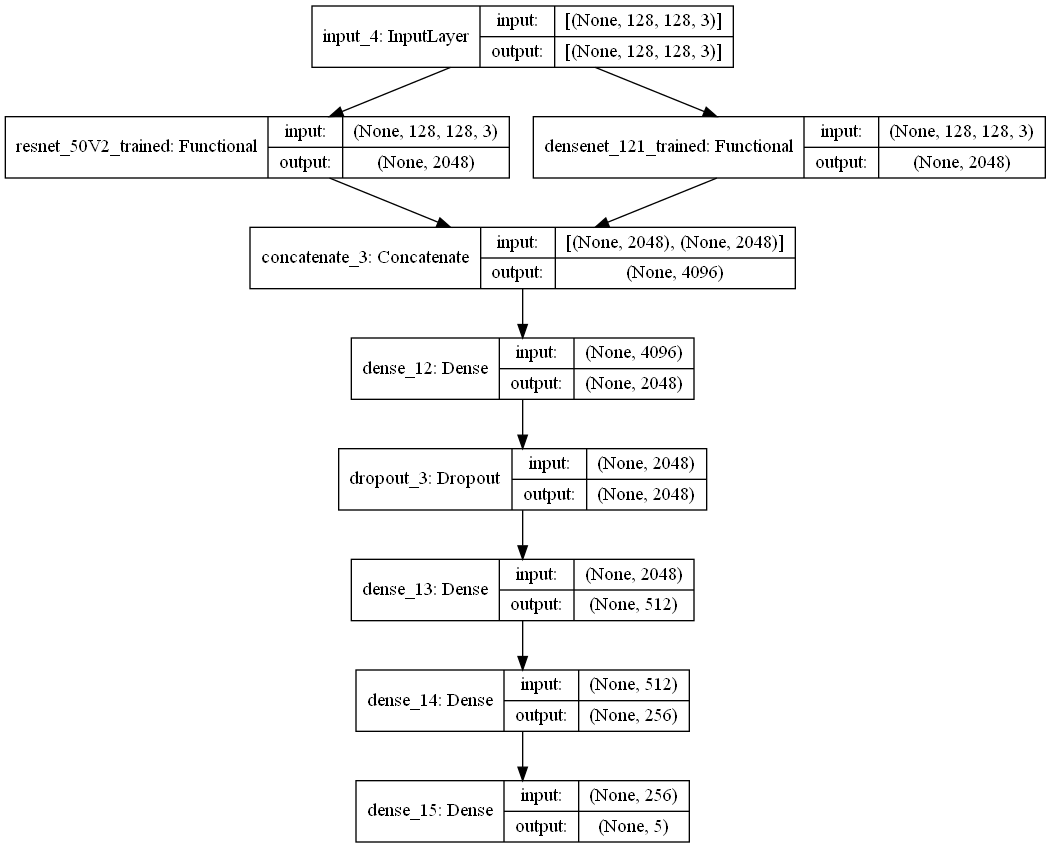

In [24]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png',show_shapes=True)

# Step 3b:
transfer learning 

### If you run into memory issues, run the code below before importing tensorflow (training on cpu is slower)

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [7]:
#Even more data augmentation
model= tf.keras.models.load_model("./concat_models/model0")

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
bs=256
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        vertical_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

train_generator = train_datagen.flow(X_train, y, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 2048)         10186304    input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 2048)         31957504    input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4096)         0           model[0][0]                      
                                                                 model_1[0][0]              

### Training was manually interrupted hence the error message

In [9]:
#step3
# start from where we ended in step 2 (same weights)
history=model.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = 2,shuffle=True)
model.save("./concat_models/model_aug") #Save step 3 for potential reuse

Epoch 1/2
58/58 [==============================] - 2211s 38s/step - loss: 2.6109 - acc: 0.9012
Epoch 2/2
 5/58 [=>............................] - ETA: 34:07 - loss: 2.1752 - acc: 0.9851

KeyboardInterrupt: 

In [10]:
model.save("./concat_models/model_aug")

INFO:tensorflow:Assets written to: ./concat_models/model_aug\assets


In [7]:
#Even more data augmentation
model= tf.keras.models.load_model("./concat_models/model_aug")
bs=512
def add_noise(img):
    '''Add random noise to an image'''
    p=np.random.uniform()
    if p>0.5:
        noise = np.random.normal(0, 5, img.shape)
        img += noise
        np.clip(img, 0., 255.)
    return img
train_datagen = ImageDataGenerator(
        shear_range=0.3,
        zoom_range=0.3,
        vertical_flip=True,
        rotation_range=35.,
        fill_mode='reflect', 
        width_shift_range = 0.15, 
        height_shift_range = 0.15,
        brightness_range=(0.3, 1.4),
        preprocessing_function=add_noise)

train_generator = train_datagen.flow(X_train, y, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

base_learning_rate = 0.00005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 2048)         10186304    input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 2048)         31957504    input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4096)         0           model[0][0]                      
                                                                 model_1[0][0]              

In [8]:
#VALIDATION ACCURACY IS MEANINGLESS HERE, I forgot to remove it
#Because we use such small number of epoch and very small learning rate, overfitting is less likely to happen
history=model.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = 1,
                   validation_data=(Xval, yval),shuffle=True)
model.save("./concat_models/model_final") #Save step 3 for potential reuse

29/29 [==============================] - 2688s 92s/step - loss: 2.2471 - acc: 0.9441 - val_loss: 2.0447 - val_acc: 0.9915
INFO:tensorflow:Assets written to: ./concat_models/model_final\assets


### Training was manually interrupted hence the error message

In [9]:
shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
y_train = y_train[shuffler]

y=tf.keras.utils.to_categorical(y_train)

bs=600
def add_noise(img):
    '''Add random noise to an image'''
    p=np.random.uniform()
    if p>0.5:
        noise = np.random.normal(0, 5, img.shape)
        img += noise
        np.clip(img, 0., 255.)
    return img
train_datagen = ImageDataGenerator(
        shear_range=0.3,
        zoom_range=0.3,
        vertical_flip=True,
        rotation_range=35.,
        fill_mode='reflect', 
        width_shift_range = 0.15, 
        height_shift_range = 0.15,
        brightness_range=(0.3, 1.4),
        preprocessing_function=add_noise)

train_generator = train_datagen.flow(X_train, y, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

base_learning_rate = 0.00005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])
model.summary()
model= tf.keras.models.load_model("./concat_models/model_final")
history=model.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = 1,
                   validation_data=(Xval, yval),shuffle=True)
model.save("./concat_models/model_final2") #Save step 3 for potential reuse

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 2048)         10186304    input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 2048)         31957504    input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4096)         0           model[0][0]                      
                                                                 model_1[0][0]              

KeyboardInterrupt: 

In [10]:
model.save("./concat_models/modelfinal2")

INFO:tensorflow:Assets written to: ./concat_models/modelfinal2\assets


In [7]:
shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
y_train = y_train[shuffler]

y=tf.keras.utils.to_categorical(y_train)

bs=700
def add_noise(img):
    '''Add random noise to an image'''
    p=np.random.uniform()
    if p>0.5:
        noise = np.random.normal(0, 10, img.shape)
        img += noise
        np.clip(img, 0., 255.)
    return img
train_datagen = ImageDataGenerator(
        shear_range=0.3,
        zoom_range=0.2,
        vertical_flip=True,
        rotation_range=38.,
        fill_mode='wrap', 
        width_shift_range = 0.16, 
        height_shift_range = 0.16,
        brightness_range=(0.3, 1.4),
        preprocessing_function=add_noise)

train_generator = train_datagen.flow(X_train, y, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

base_learning_rate = 0.00003
model= tf.keras.models.load_model("./concat_models/modelfinal2")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss='categorical_crossentropy', metrics = ['acc'])
model.summary()

history=model.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = 1,
                   validation_data=(Xval, yval),shuffle=True)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 2048)         10186304    input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 2048)         31957504    input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 4096)         0           model[0][0]                      
                                                                 model_1[0][0]              

In [8]:
model.save("./concat_models/modelfinal_contact")

INFO:tensorflow:Assets written to: ./concat_models/modelfinal3\assets


<h3>Lion mail drive link to the model: <a href="https://drive.google.com/drive/folders/13LU6Z5qObxH6pxdUo9N531-eqFGlvAIV?usp=sharing">https://drive.google.com/drive/folders/13LU6Z5qObxH6pxdUo9N531-eqFGlvAIV?usp=sharing</a></h3>

## Generating the .csv file for Kaggle



In [7]:
finalmodel = tf.keras.models.load_model("./concat_models/modelfinal_contact")

# Note that TTA does not always consistenly output the same predictions
because different augmentation parameters are randomly chosen every time.


Because inference performance is not a priority, tta steps can be unreasonably high, and yield marginaly better predictions

In [8]:
#FINAL PREDICTION OBTAINED WITH TTA

from tqdm import tqdm
tta_steps = 20
predictions = []
bs=64
test_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        vertical_flip=True,
        rotation_range=10.,
        fill_mode='reflect', 
        width_shift_range = 0.1, 
        height_shift_range = 0.1,
        brightness_range=(0.8, 1.1)
        )
for i in tqdm(range(tta_steps)):
    preds = finalmodel.predict(test_datagen.flow(X_test, batch_size=bs, shuffle=False), steps = len(X_test)/bs)
    predictions.append(preds)
    
final_pred = np.mean(predictions, axis=0)

predicted_values_generated_by_your_model= tf.argmax(final_pred, axis=1) # right format


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:42<00:00, 11.13s/it]


In [11]:
import csv
with open('predicted2.csv','w') as csvfile:
    fieldnames = ['Id','label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for index,l in enumerate(predicted_values_generated_by_your_model.numpy()):
        filename = str(index) + '.png'
        label = str(l)
        writer.writerow({'Id': filename, 'label': label})

In [1]:
!sudo apt-get install tree
!tree ./ >> README.md

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following packages were automatically installed and are no longer required:
  libnuma1 linux-gcp-5.4-headers-5.4.0-1052
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.
